# Training a shallow classifier
## Histogram of Gradients (HoG)

In [1]:
# generic
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
import itertools
import matplotlib
#matplotlib.style.use('ggplot')

# sklearn
from sklearn import cross_validation, grid_search
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# files in repository
from plot_cm import plot_confusion_matrix
from features import color_histogram_hsv, hog_feature,extract_features,rgb2gray

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_

Importing data

In [2]:
train = h5py.File('datasets/datatraining.h5','r')
test = h5py.File('datasets/datatest.h5','r')
X_train, y_train = train['data'][:], train['labels'][:]
X_test, y_test = test['data'][:], test['labels'][:]

Reshaping data for the purpose of using functions from $features.py$ taken from http://cs231n.github.io/assignments2016/assignment1/ 

In [3]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
X_train = X_train.reshape(5000, 3, 32, 32).transpose(0,2,3,1).astype("float")
X_test = X_test.reshape(1000, 3, 32, 32).transpose(0,2,3,1).astype("float")

### Feature extraction using HoG

In [4]:
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=10)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_test_feats = extract_features(X_test, feature_fns)

# Subtracting the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_test_feats -= mean_feat

# Dividing by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_test_feats /= std_feat

# Adding a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 5000 images
Done extracting features for 2000 / 5000 images
Done extracting features for 3000 / 5000 images
Done extracting features for 4000 / 5000 images


### Training SVM

In [14]:
clf = SVC(decision_function_shape='ovr',C=10, gamma=0.01,verbose = 3,kernel='rbf')
clf.fit(X_train_feats, y_train)

[LibSVM]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=3)

### Validating the model

In [15]:
y_predict=clf.predict(X_test_feats)
print("\nClassification report:")
print(classification_report(y_test, y_predict))
print("The accuracy is {:.1f}%".format(accuracy_score(y_test, y_predict, normalize=True)*100))


Classification report:
             precision    recall  f1-score   support

          0       0.54      0.61      0.58       100
          1       0.64      0.71      0.67       100
          2       0.41      0.34      0.37       100
          3       0.37      0.39      0.38       100
          4       0.42      0.44      0.43       100
          5       0.38      0.38      0.38       100
          6       0.54      0.60      0.57       100
          7       0.55      0.52      0.53       100
          8       0.61      0.53      0.57       100
          9       0.64      0.57      0.60       100

avg / total       0.51      0.51      0.51      1000

The accuracy is 50.9%


### Confusion matrix

Confusion matrix, without normalization
[[61  2  6  1  3  2  2  1 19  3]
 [ 7 71  1  1  0  4  2  0  7  7]
 [ 8  1 34 10 19 14  9  4  1  0]
 [ 3  3  9 39  7 12 13  8  2  4]
 [ 1  4  9 11 44 11 11  8  0  1]
 [ 4  1  8 23  4 38  9  8  1  4]
 [ 2  4  6  7 11  6 60  4  0  0]
 [ 4  2  5  9 14  5  3 52  0  6]
 [21 11  3  1  1  2  1  0 53  7]
 [ 1 12  2  3  3  6  2 10  4 57]]


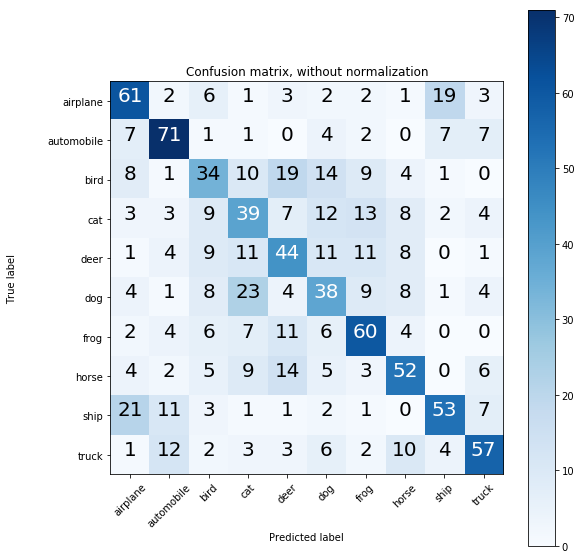

In [16]:
# Computing confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict, labels=[int(i) for i in range(len(classes))])
np.set_printoptions(precision=2)

# Plotting non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes,
                      title='Confusion matrix, without normalization')
plt.savefig("presentation_images/shallow_test.png")